# Data visualization for example 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
plt.style.use('seaborn-notebook')
from utils import eegml_data_load
%matplotlib inline

## Make a dataframe of file meta data

In [2]:
files_df = eegml_data_load.create_files_df()
files_df.head()

,dir_name,file_name,path,patient,preictal,train,file_id
0,test_1_new,new_1_1.mat,test_1_new/new_1_1.mat,1,-1,0,0
1,test_1_new,new_1_10.mat,test_1_new/new_1_10.mat,1,-1,0,1
2,test_1_new,new_1_100.mat,test_1_new/new_1_100.mat,1,-1,0,2
3,test_1_new,new_1_101.mat,test_1_new/new_1_101.mat,1,-1,0,3
4,test_1_new,new_1_102.mat,test_1_new/new_1_102.mat,1,-1,0,4


## Get temporal and frequency data for example

In [3]:
inter_ex = files_df[files_df['preictal']==0].iloc[0,:]
pre_ex = files_df[files_df['preictal']==1].iloc[0,:]

time, inter_temp = eegml_data_load.load_temporal_data(inter_ex['path'])
time, pre_temp = eegml_data_load.load_temporal_data(pre_ex['path'])
freq, inter_power = eegml_data_load.load_power_data(inter_ex['path'])
freq, pre_power = eegml_data_load.load_power_data(pre_ex['path'])

print(inter_temp.shape)
print(pre_temp.shape)
print(inter_power.shape)
print(pre_power.shape)

(16, 240000)
(16, 240000)
(16, 120000)
(16, 120000)


## Plot temporal and frequency data.

In [4]:
def plot_pre_vs_inter(x,y_pre,y_inter,samples,num_channels):
    fig, axs = plt.subplots(num_channels, 1, figsize=(15, 15))
    for i in range(num_channels):
        axs[i].plot(x[:samples],y_pre[i,:samples], color='red', label='pre')
        axs[i].plot(x[:samples],y_inter[i,:samples], color='black', label='inter')
    axs[0].legend(loc='upper right', bbox_to_anchor=(.5, 1.3),fontsize=12)
    plt.show()

### Plot temporal data per channel 

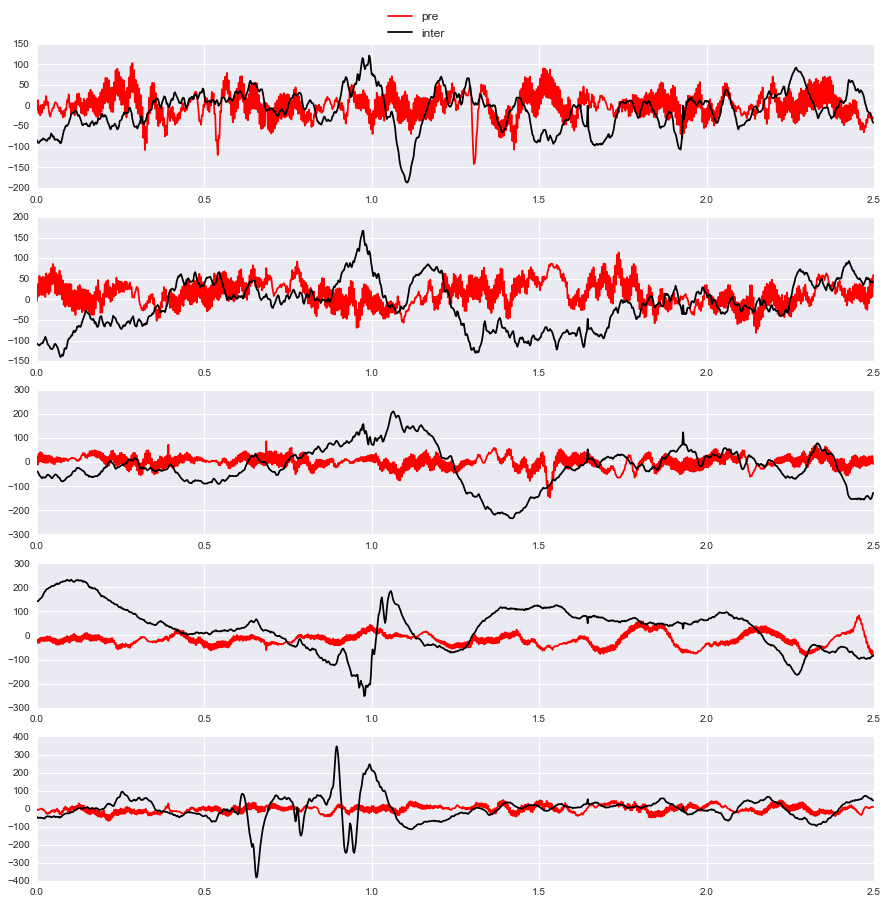

In [5]:
plot_pre_vs_inter(time, pre_temp, inter_temp,1000,5)

### Plot the power spectra per channel

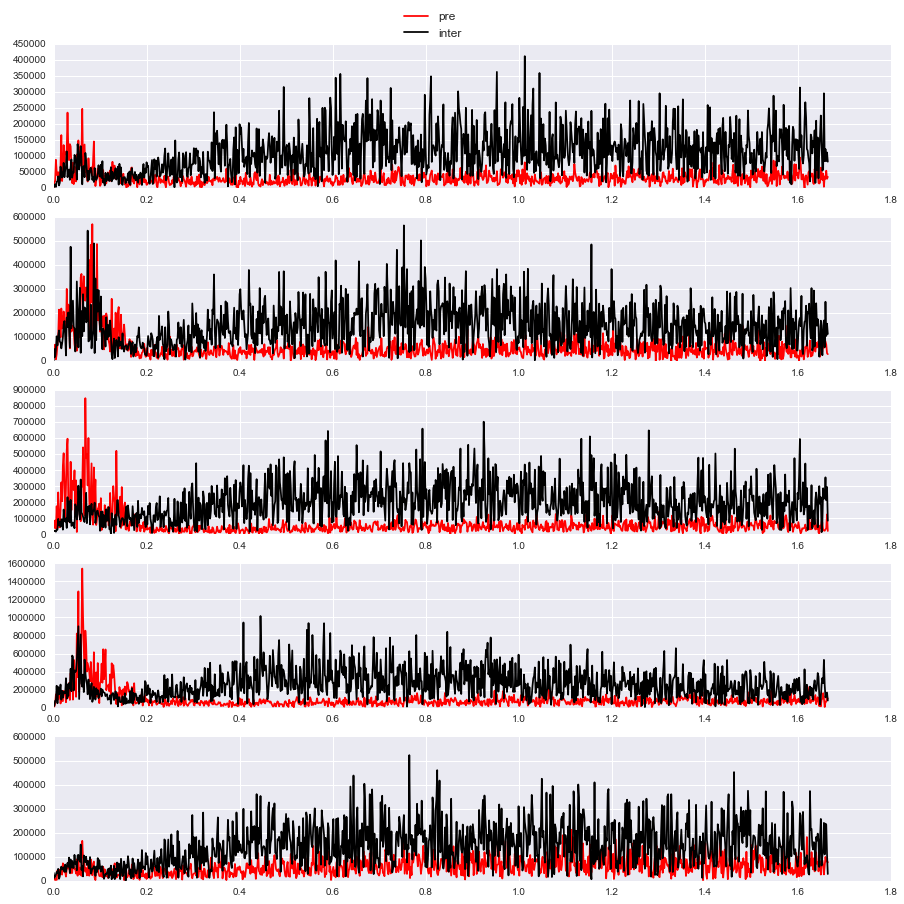

In [6]:
plot_pre_vs_inter(freq, pre_power, inter_power,1000,5)

### Plot normalized power spectra.

In [7]:
# What is the overall power difference per channel?
inter_power.sum(axis=1)-pre_power.sum(axis=1)

array([  5.21157786e+07,   2.19332065e+08,   3.17173596e+08,
         4.71197734e+08,   6.58272914e+08,   3.98490603e+08,
         3.29419140e+08,   3.28297567e+08,   3.57332782e+08,
         5.74277559e+08,   6.32383940e+08,   8.19908032e+08,
         8.14447157e+08,   7.77691427e+08,   7.99986454e+08,
         3.97408943e+08])

In [8]:
# Normalize power spectra.
norm_inter_power = (inter_power.T/inter_power.sum(axis=1)).T
norm_pre_power = (pre_power.T/pre_power.sum(axis=1)).T
norm_pre_power[0,:].sum()

1.0000000000000002

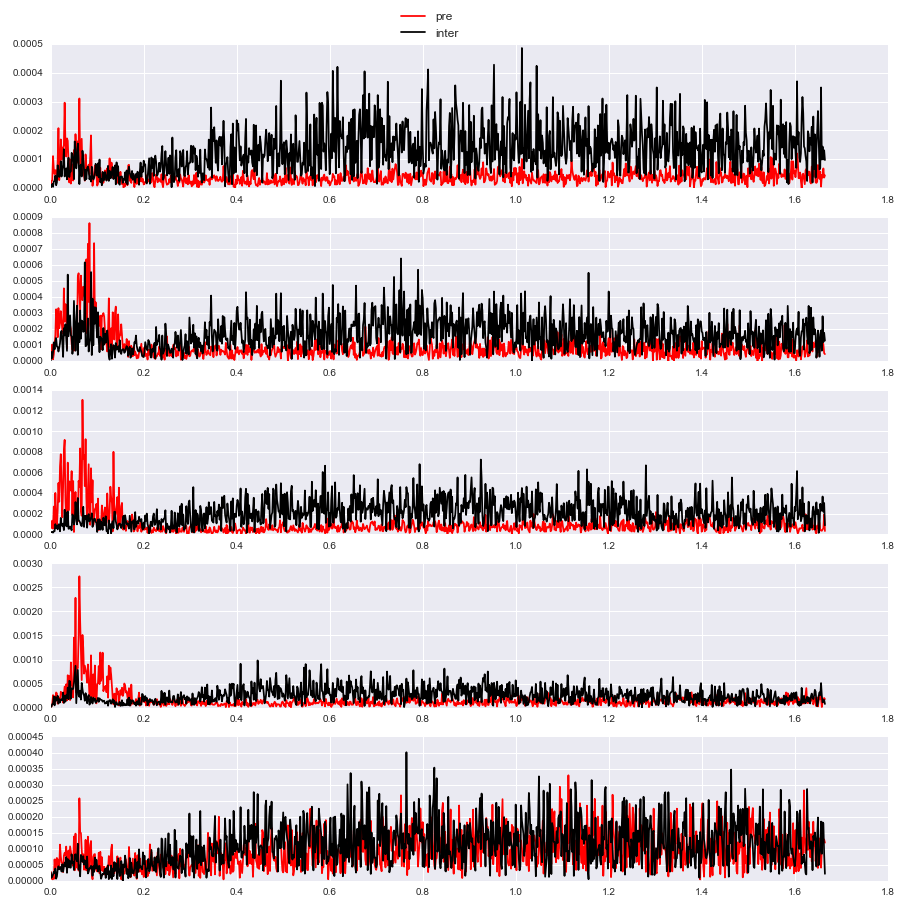

In [9]:
# Plot normalized power spectra.
plot_pre_vs_inter(freq, norm_pre_power, norm_inter_power,1000,5)

### Plot a binned version of normalized power spectra.

In [10]:
def bin_power(x,bin_size):
    return np.sum(x.reshape(-1, bin_size), axis=1)

bin_size = 200 # number of bins to smooth over
num_channels = norm_pre_power.shape[0]
bin_norm_pre_power = np.array([bin_power(norm_pre_power[i,:], bin_size) for i in np.arange(num_channels)])
bin_norm_inter_power = np.array([bin_power(norm_inter_power[i,:], bin_size) for i in np.arange(num_channels)])
bin_norm_pre_power.shape

(16, 600)

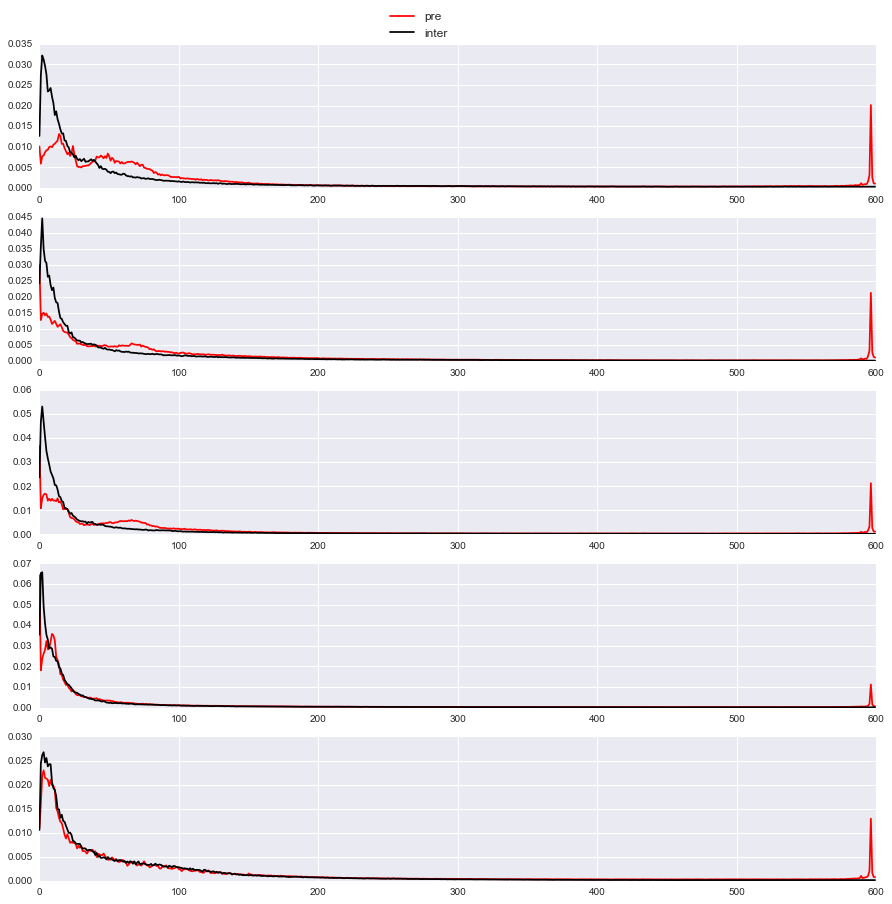

In [11]:
binned_length = bin_norm_pre_power.shape[1]
plot_pre_vs_inter(np.arange(binned_length), bin_norm_pre_power, bin_norm_inter_power,binned_length,5)

### Evaluate binned power as candidate features on small sample

In [12]:
def normalize_and_bin_power_spectra(power, bin_size):

    def bin_power(x,bin_size):
        return np.sum(x.reshape(-1, bin_size), axis=1)

    # Normalize power spectra.
    norm_power = (power.T/power.sum(axis=1)).T
    
    # Bin normalized power spectra. 
    num_channels = power.shape[0]
    bin_norm_power = np.array([bin_power(norm_power[i,:], bin_size) for i in np.arange(num_channels)])
    
    return bin_norm_power

In [13]:
%%time
sample_size = 10 # number of observations to experiment with
bin_size = 200 # number of bins to average over

inter_exs = files_df[files_df['preictal']==0]
pre_exs = files_df[files_df['preictal']==1]
    
bin_norm_inter_power_mat = []
bin_norm_pre_power_mat = []
for i in range(sample_size):
    print(str(i)+str(" "), end="")
    
    inter_ex = inter_exs.iloc[i,:]
    pre_ex = pre_exs.iloc[i,:]
        
    # Load power data.
    freq, inter_power = eegml_data_load.load_power_data(inter_ex['path'])
    freq, pre_power = eegml_data_load.load_power_data(pre_ex['path'])
    
    # Normalize and bin power spectra.
    bin_norm_inter_power = normalize_and_bin_power_spectra(inter_power, bin_size)
    bin_norm_pre_power = normalize_and_bin_power_spectra(pre_power, bin_size)
    
    # Concatenate result.
    bin_norm_inter_power_mat.append(bin_norm_inter_power)
    bin_norm_pre_power_mat.append(bin_norm_pre_power)

bin_norm_inter_power_mat = np.array([item for sublist in bin_norm_inter_power_mat for item in sublist])
bin_norm_pre_power_mat = np.array([item for sublist in bin_norm_pre_power_mat for item in sublist])

bin_norm_pre_power_mat.shape

0 1 2 3 4 5 6 7 8 9 CPU times: user 16.4 s, sys: 7.95 s, total: 24.3 s
Wall time: 25.7 s


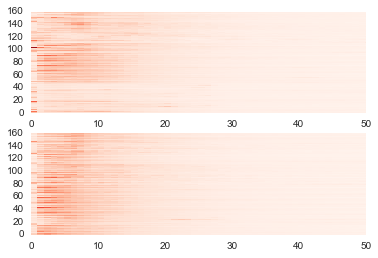

In [14]:
num_observations = bin_norm_pre_power_mat.shape[0]
num_freqs = 50#bin_norm_pre_power_mat.shape[1]
pre_to_plot = bin_norm_pre_power_mat[:num_observations,:]
inter_to_plot = bin_norm_inter_power_mat[:num_observations,:]
cbar_max = max(pre_to_plot.max(),inter_to_plot.max())

fix,ax = plt.subplots(2)
ax[0].pcolormesh(pre_to_plot,cmap=plt.cm.Reds, vmin=0, vmax=cbar_max)
ax[0].set_xlim(0, num_freqs)
ax[1].pcolormesh(inter_to_plot,cmap=plt.cm.Reds, vmin=0, vmax=cbar_max)
ax[1].set_xlim(0, num_freqs)
plt.show()